In [5]:
import numpy as np
import pandas as pd
import networkx as nx
import graphviz
import matplotlib.pyplot as plt

In [6]:
# read dataset and adjust delimiters for reading
df = pd.read_csv("GPS_Data_Simplified_2D_Feature_Map.csv", delimiter=";")

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col].str.replace(",", ".", regex=False), errors="coerce")

In [7]:
# Add labels to identify the three types of attack
df['State'] = df['Output'].map({
    0: 'Safe',
    1: 'SimplisticAttack',
    2: 'IntermediateAttack',
    3: 'SophisticatedAttack'
})
df.head(10)

,PRN,DO,PD,RX,TOW,CP,EC,LC,PC,PIP,PQP,TCD,CN0,Output,State
0,6,1160.671408,-238359.5433,491568.00,491568.0008,-24660.26329,163521.78,170008.81,179294.97,178420.33,-17688.17800,1158.4806,49.412529,0,Safe
1,6,1157.827808,-238363.9212,491568.02,491568.0208,-24683.46852,158277.05,160253.09,182106.11,182106.05,158.33333,1160.7948,49.452686,0,Safe
2,6,1161.135932,-238368.6386,491568.04,491568.0408,-24706.68736,184442.36,193125.89,208228.02,-205198.30,35391.59000,1157.6909,49.480145,0,Safe
3,6,1161.156617,-238373.3918,491568.06,491568.0608,-24729.92004,159812.45,169960.55,187550.72,187543.00,-1701.94400,1161.1343,49.433769,0,Safe
4,6,1160.690893,-238378.1271,491568.08,491568.0808,-24753.15400,183557.66,191912.58,208403.50,208330.05,-5532.89990,1161.1759,49.391670,0,Safe
5,6,1160.807697,-238382.7373,491568.10,491568.1008,-24776.37474,178968.47,184958.66,198938.81,198488.98,-13370.64100,1160.6908,49.290367,0,Safe
6,6,1163.400529,-238386.9722,491568.12,491568.1208,-24799.60779,168080.86,173257.44,185404.97,-184959.58,12843.65700,1160.6932,49.303074,0,Safe
7,6,1159.350641,-238391.2251,491568.14,491568.1408,-24822.83854,153961.95,162982.91,169926.69,169467.23,12487.34200,1163.5721,49.371311,0,Safe
8,6,1161.657926,-238395.2635,491568.16,491568.1608,-24846.06411,178182.84,177790.19,194533.20,-192402.30,28714.55300,1159.2557,49.421207,0,Safe
9,6,1161.995499,-238399.5520,491568.18,491568.1808,-24869.29044,160029.16,160199.95,180339.83,-180306.16,3484.41430,1161.6427,49.396267,0,Safe


In [8]:
# Sort the DataFrame by the 'TOW' column
# We will use 'TOW' as the primary sort key, and 'RX' as a secondary one to break any ties.
df = df.sort_values(by=['TOW', 'RX'], ascending=True).reset_index(drop=True)

print("Shape of the sorted data:", df.shape)
print("\nFirst 10 rows of the sorted data:")
print(df.head(10))

Shape of the sorted data: (510530, 15)

First 10 rows of the sorted data:
   PRN           DO           PD         RX         TOW           CP  \
0   26 -1407.495077 -2397690.634  173640.00  173640.008  37759.75100   
1   26 -1406.742979 -2397690.634  173640.00  173640.008  37759.75100   
2   26 -1405.308935 -2397685.166  173640.02  173640.028  37787.93074   
3   26 -1406.774068 -2397685.166  173640.02  173640.028  37787.93074   
4   26 -1406.987716 -2397679.895  173640.04  173640.048  37816.12306   
5   26 -1408.696630 -2397679.895  173640.04  173640.048  37816.12306   
6   26 -1405.867855 -2397674.499  173640.06  173640.068  37844.30873   
7   26 -1406.626045 -2397674.499  173640.06  173640.068  37844.30873   
8   26 -1407.427479 -2397669.183  173640.08  173640.088  37872.48590   
9   26 -1409.272073 -2397669.183  173640.08  173640.088  37872.48590   

             EC           LC           PC           PIP            PQP  \
0  125018.70310  145129.7344  152941.6406  152666.25000    

In [9]:
# Population count - number of samples for each state
# Total samples
total_samples = len(df)

# Sample count per state
population = df['State'].value_counts()

# Utilization (percentage of total)
utilization = (population / total_samples) * 100

# Combine into one DataFrame
summary_table = pd.DataFrame({
    'Sample Count': population,
    'Percentage (%)': utilization.round(2)
})

# Display the table
display(summary_table)

,Sample Count,Percentage (%)
State,,
Safe,397825,77.92
IntermediateAttack,44232,8.66
SimplisticAttack,36458,7.14
SophisticatedAttack,32015,6.27


In [10]:
# Remove unnecessary columns
columns_to_keep = ['TOW', 'RX', 'PRN', 'CN0', 'Output']
df = df.loc[:, columns_to_keep]
df['Output'] = pd.to_numeric(df['Output'], errors='coerce')
df.dropna(inplace=True)

# Handle Duplicate Timestamps
# Sort by TOW (time), CN0 (signal quality), and Output (attack priority)
df = df.sort_values(
    by=['TOW', 'CN0', 'Output'],
    ascending=[True, False, False]
)

# Drop duplicates based on TOW, keeping only the best row according to our sort
df_cleaned = df.drop_duplicates(subset=['TOW'], keep='first')

# Sort the final dataset by time and reset the index for a clean output
df_final = df_cleaned.sort_values(by='TOW').reset_index(drop=True)

print("Data cleaning complete.")
print(f"Original dataset had {len(df)} rows (after initial NaN removal).")
print(f"Final cleaned dataset has {len(df_final)} rows.")

Data cleaning complete.
Original dataset had 510530 rows (after initial NaN removal).
Final cleaned dataset has 434613 rows.
Result saved to 'GPS_Data_Cleaned_Final.csv'


In [11]:
df = df_final
# Find the earliest and latest timestamps in the 'TOW' column
min_tow = df['TOW'].min()
max_tow = df['TOW'].max()

# Calculate the total duration by subtracting the first from the last
total_duration_seconds = max_tow - min_tow

print("--- Total Time Analysis ---")
print(f"First timestamp (TOW): {min_tow:.4f} seconds")
print(f"Last timestamp (TOW):  {max_tow:.4f} seconds")
print("-" * 30)
print(f"Total elapsed time including gaps: {total_duration_seconds:.4f} seconds")

--- Total Time Analysis ---
First timestamp (TOW): 173640.0080 seconds
Last timestamp (TOW):  492039.3411 seconds
------------------------------
Total elapsed time including gaps: 318399.3331 seconds


In [12]:
# --- Calculate the Transition Probability Matrix (P-matrix) ---
# Define the possible states your system can be in
possible_states = [0, 1, 2, 3]

# Count the total number of steps the system spent in each state
state_counts = df['Output'].value_counts().reindex(possible_states, fill_value=0)

# Create an empty matrix to hold the count of each transition
transition_counts = pd.DataFrame(0, index=possible_states, columns=possible_states)

# Iterate through the data to count transitions from one step to the next
for i in range(1, len(df)):
    start_state = int(df.loc[i-1, 'Output'])
    end_state = int(df.loc[i, 'Output'])
    if start_state in possible_states and end_state in possible_states:
        transition_counts.loc[start_state, end_state] += 1

# Calculate the P-matrix by dividing transition counts by the total counts for each state
# This gives the probability of moving from a state to another
p_matrix = transition_counts.div(state_counts, axis=0).fillna(0)

# --- Calculate Steady-State Probabilities (π) ---
# To find the steady-state vector π, we solve the eigenvector equation πP = π
# This is equivalent to finding the eigenvector of P for the eigenvalue 1.
# We solve the linear system (P' - I)π = 0, subject to Σπ = 1.

# Get the matrix (P' - I)
eigen_matrix = p_matrix.transpose() - np.identity(len(possible_states))

# Append a row of all 1s to incorporate the Σπ = 1 constraint
A = np.vstack((eigen_matrix[:-1], np.ones(len(possible_states))))

# Create the results vector b (all 0s and one 1)
b = np.zeros(len(possible_states))
b[-1] = 1

# Solve the linear system A*π = b
pi = np.linalg.solve(A, b)

# --- Calculate and Display DTMC Performance Metrics ---

print("--- DTMC Performance Analysis ---")
print(f"\nNumber of States: {len(possible_states)}")

print("\nTransition Probability Matrix (P):")
with pd.option_context('display.float_format', '{:,.4f}'.format):
  print(p_matrix)

print("\nSteady-State Probabilities (π):")
for i, p in enumerate(pi):
    print(f"  π({i}): {p:.4f}  (System is in State {i} for {p:.2%} of the steps)")

# Utilization (U): Probability of being in any attack state
utilization = 1 - pi[0]
print(f"\nUtilization (U): {utilization:.4f}")
print(f"  (The system is under attack in {utilization:.2%} of the steps)")

# Average Attack Severity (N)
avg_severity = np.sum(pi * np.array(possible_states))
print(f"\nAverage Attack Severity (N): {avg_severity:.4f}")
print("  (The weighted average of the system's state per step)")

# Mean Recurrence Time (W): Average number of steps to return to a state
print("\nMean Recurrence Time (W) per State:")
for i in possible_states:
    recurrence_time = 1 / pi[i] if pi[i] > 0 else float('inf')
    print(f"  State {i}: {recurrence_time:.2f} steps (on average, to return to this state)")

--- DTMC Performance Analysis ---

Number of States: 4

Transition Probability Matrix (P):
       0      1      2      3
0 0.8310 0.0568 0.0779 0.0343
1 0.7571 0.0775 0.1655 0.0000
2 0.6313 0.1574 0.2113 0.0000
3 0.3929 0.0000 0.0000 0.6071

Steady-State Probabilities (π):
  π(0): 0.7785  (System is in State 0 for 77.85% of the steps)
  π(1): 0.0633  (System is in State 1 for 6.33% of the steps)
  π(2): 0.0902  (System is in State 2 for 9.02% of the steps)
  π(3): 0.0680  (System is in State 3 for 6.80% of the steps)

Utilization (U): 0.2215
  (The system is under attack in 22.15% of the steps)

Average Attack Severity (N): 0.4477
  (The weighted average of the system's state per step)

Mean Recurrence Time (W) per State:
  State 0: 1.28 steps (on average, to return to this state)
  State 1: 15.79 steps (on average, to return to this state)
  State 2: 11.09 steps (on average, to return to this state)
  State 3: 14.70 steps (on average, to return to this state)


Running analysis to get the P-matrix...
Generating simple diagram with Matplotlib and NetworkX...


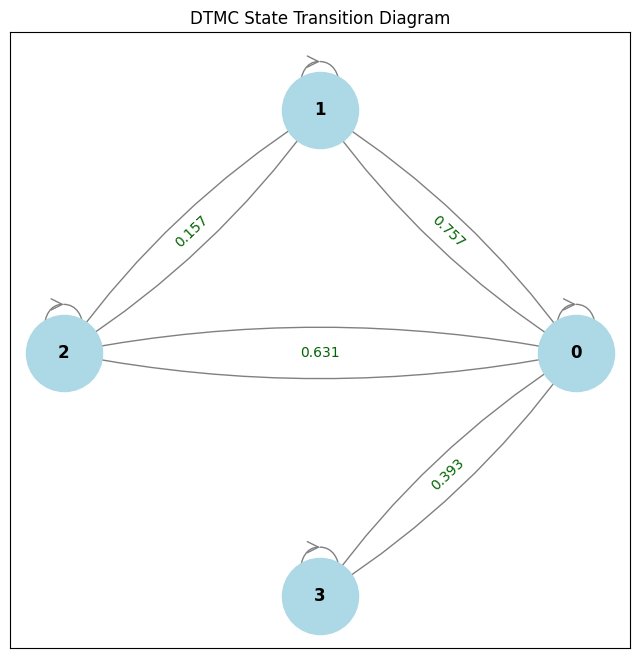

In [13]:
# --- Step 1 & 2: Load Data and Calculate P-Matrix ---
print("Running analysis to get the P-matrix...")

possible_states = sorted(df['Output'].unique().astype(int))
state_counts = df['Output'].value_counts().reindex(possible_states, fill_value=0)
transition_counts = pd.DataFrame(0, index=possible_states, columns=possible_states)

for i in range(1, len(df)):
    start_state = int(df.loc[i-1, 'Output'])
    end_state = int(df.loc[i, 'Output'])
    if start_state in possible_states and end_state in possible_states:
        transition_counts.loc[start_state, end_state] += 1

p_matrix = transition_counts.div(state_counts, axis=0).fillna(0)


# --- Step 3: Create and Draw the Diagram ---
print("Generating simple diagram with Matplotlib and NetworkX...")

# Create a directed graph object
G = nx.DiGraph()

# Add edges to the graph from the P-matrix
for start_state, row in p_matrix.iterrows():
    for end_state, prob in row.items():
        if prob > 0.001:  # Only add an edge if the probability is significant
            G.add_edge(start_state, end_state, weight=prob)

# Use a layout for the nodes
pos = nx.circular_layout(G)

# Create the plot
plt.figure(figsize=(8, 8))

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')

# Draw the node labels (the state numbers)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray',
                       arrows=True, arrowstyle='->', arrowsize=20,
                       connectionstyle='arc3,rad=0.1')

# Draw the edge labels (the probabilities)
edge_labels = nx.get_edge_attributes(G, 'weight')
formatted_edge_labels = {k: f"{v:.3f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels,
                             font_color='darkgreen', font_size=10)

# Display the plot
plt.title("DTMC State Transition Diagram", size=12)
plt.show()